In [231]:
import pyspark_csv as pycsv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import path
import random
from wordcloud import WordCloud, STOPWORDS, get_single_color_func

In [232]:
sc.addPyFile('pyspark_csv.py')
plaintext_rdd = sc.textFile('data/properati-AR-2017-08-01-properties-sell.csv')
dataframe = pycsv.csvToDataFrame(sqlCtx, plaintext_rdd)
data = dataframe.rdd

In [233]:
data.first()

Row(id='c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2', created_on=datetime.datetime(2012, 9, 19, 0, 0), operation='sell', property_type='house', place_name='San Antonio De Padua', place_with_parent_names='|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San Antonio De Padua|', country_name='Argentina', state_name='Bs.As. G.B.A. Zona Oeste', geonames_id=3429244, lat-lon=None, lat=None, lon=None, price=120000, currency='USD', price_aprox_local_currency=2117340.0, price_aprox_usd=120000.0, surface_total_in_m2=333, surface_covered_in_m2=93, price_usd_per_m2=360.36036036036035, price_per_m2=1290.3225806451612, floor=None, rooms=None, expenses=None, properati_url='http://www.properati.com.ar/udh_venta_casa_merlo_av-argentina-1900_', description='CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS, COCINA, COMEDOR, LAVADERO, JARDÍN. -  - J. ATTAGUILE PROPIEDADES', title='CASA EN VENTA', image_thumbnail='https://thumbs4.properati.com/1/ufoyqwscVk8n3e0ZtIAiZmtptj0=/trim/198x0/smart/filters:strip_icc()/xintelwe

# Solo capital federal y GBA

In [234]:
data_gba_and_capi = data.filter(lambda row: row.state_name.find('G.B.A') != -1 or row.state_name.find('Capital Federal') )

In [235]:
#data_gba_and_capi = data_gba_and_capi.filter(lambda row: row.description)

# Agrupo por tipo de propiedad (solo apartmento y casa)

In [236]:
group_apartment = data_gba_and_capi.filter(lambda row: row.property_type == "apartment")
group_house = data_gba_and_capi.filter(lambda row: row.property_type == "house")

In [237]:
data_gba_and_capi.first()

Row(id='c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2', created_on=datetime.datetime(2012, 9, 19, 0, 0), operation='sell', property_type='house', place_name='San Antonio De Padua', place_with_parent_names='|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San Antonio De Padua|', country_name='Argentina', state_name='Bs.As. G.B.A. Zona Oeste', geonames_id=3429244, lat-lon=None, lat=None, lon=None, price=120000, currency='USD', price_aprox_local_currency=2117340.0, price_aprox_usd=120000.0, surface_total_in_m2=333, surface_covered_in_m2=93, price_usd_per_m2=360.36036036036035, price_per_m2=1290.3225806451612, floor=None, rooms=None, expenses=None, properati_url='http://www.properati.com.ar/udh_venta_casa_merlo_av-argentina-1900_', description='CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS, COCINA, COMEDOR, LAVADERO, JARDÍN. -  - J. ATTAGUILE PROPIEDADES', title='CASA EN VENTA', image_thumbnail='https://thumbs4.properati.com/1/ufoyqwscVk8n3e0ZtIAiZmtptj0=/trim/198x0/smart/filters:strip_icc()/xintelwe

# Hacemos un split de cada palabra en la descripcion

In [269]:
all_properties_descrip = data_gba_and_capi.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")
group_house_descrip = group_house.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")
group_apartment_descrip = group_apartment.flatMap(lambda row: row.description.split() if row.description is not None \
                                         else "")


In [271]:
all_properties_descripCountRDD = all_properties_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':'),1))
group_house_descripCountRDD = group_house_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':'),1))
group_apartment_descripCountRDD = group_apartment_descrip.map(lambda word: (str.lower(word).rstrip(',').rstrip('.')\
                                .rstrip(':'),1))

In [272]:
all_properties_descripCountRDD.take(10)

[('casa', 1),
 ('con', 1),
 ('local', 1),
 ('en', 1),
 ('venta', 1),
 ('en', 1),
 ('padua.2', 1),
 ('dormitorios', 1),
 ('cocina', 1),
 ('comedor', 1)]

In [273]:
all_properties_descripCountRDD = all_properties_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()
group_house_descripCountRDD = group_house_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()
group_apartment_descripCountRDD = group_apartment_descripCountRDD.reduceByKey(lambda a,b: a+b ).cache()

In [274]:
all_properties_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(10)

[('de', 840206),
 ('con', 515803),
 ('y', 478586),
 ('en', 371917),
 ('a', 214882),
 ('la', 194706),
 ('-', 170064),
 ('el', 138015),
 ('cocina', 115909),
 ('por', 109614)]

In [289]:
preposiciones = ["a","ante","cabe","bajo","con","contra","de","desde","durante","en","entre","hacia","hasta",\
                "mediante","para","por","segun","sin","sobre","tras"]

otras_palabras = ["y","con","en","la","las","el","al","-","del","1","uno","una","2","dos","3","tres","se","los","un",\
                 "que","es","o","4",",",".","m2","metros","son","x","en:","/","por:","no","null.","su","publicado",\
                  "venta","cuenta","ubicado","zona","precio","tiene","usd","esta","unidades","medidas","5","tipo",\
                 "como","más","av.","mts","+","#","este","id","superficie","u$s","10","cada","sus","6","*","24",\
                 "$","lo","está","ubicación","casa","apartamento","departamento","edificios","edificio",\
                  "departamentos","propiedades","codigo:","e",""]


In [290]:
all_properties_descripCountRDD = all_properties_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [291]:
group_house_descripCountRDD = group_house_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [292]:
group_apartment_descripCountRDD = group_apartment_descripCountRDD.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [293]:
all_properties_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(200)

[('cocina', 115909),
 ('baño', 102850),
 ('comedor', 102264),
 ('dormitorios', 84091),
 ('living', 70792),
 ('dormitorio', 56899),
 ('ambientes', 53726),
 ('completo', 50585),
 ('planta', 49105),
 ('piso', 45265),
 ('muy', 45199),
 ('lavadero', 42762),
 ('pisos', 42737),
 ('amplio', 40677),
 ('frente', 40632),
 ('excelente', 37863),
 ('parrilla', 34211),
 ('cochera', 34182),
 ('suite', 33604),
 ('placard', 31680),
 ('patio', 28700),
 ('vista', 28132),
 ('balcón', 27218),
 ('terraza', 26610),
 ('baja', 26010),
 ('mesada', 25331),
 ('propiedad', 24790),
 ('pileta', 24689),
 ('calle', 24516),
 ('gran', 24455),
 ('alta', 24034),
 ('barrio', 23532),
 ('principal', 23258),
 ('lote', 22299),
 ('toilette', 22221),
 ('entrada', 20884),
 ('madera', 20714),
 ('doble', 20209),
 ('todos', 19829),
 ('vestidor', 19691),
 ('servicio', 19614),
 ('acceso', 19509),
 ('baños', 19356),
 ('calidad', 18403),
 ('hall', 17737),
 ('través', 17640),
 ('salida', 17454),
 ('quincho', 17356),
 ('muebles', 17349),
 

In [294]:
group_house_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(200)

[('comedor', 61550),
 ('baño', 58499),
 ('cocina', 54515),
 ('dormitorios', 51353),
 ('living', 40860),
 ('planta', 31048),
 ('lavadero', 27287),
 ('completo', 24834),
 ('suite', 24700),
 ('muy', 24005),
 ('amplio', 23098),
 ('parrilla', 22781),
 ('dormitorio', 22761),
 ('lote', 20405),
 ('excelente', 17821),
 ('propiedad', 17569),
 ('ambientes', 17294),
 ('patio', 17113),
 ('alta', 16767),
 ('pileta', 16573),
 ('principal', 16330),
 ('frente', 15890),
 ('pisos', 15403),
 ('toilette', 15143),
 ('entrada', 14967),
 ('gran', 14775),
 ('servicio', 14640),
 ('barrio', 14498),
 ('vestidor', 14423),
 ('cochera', 14160),
 ('baja', 14035),
 ('diario', 13702),
 ('quincho', 13289),
 ('doble', 12582),
 ('placard', 12220),
 ('jardín', 12191),
 ('autos', 12070),
 ('piso', 12037),
 ('hall', 11905),
 ('plantas', 11869),
 ('vista', 11821),
 ('garage', 11791),
 ('madera', 11730),
 ('parque', 11278),
 ('escritorio', 11189),
 ('chalet', 10540),
 ('todos', 10324),
 ('fondo', 10166),
 ('galería', 10100),
 

In [295]:
group_apartment_descripCountRDD.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(200)

[('cocina', 54990),
 ('baño', 38163),
 ('comedor', 35287),
 ('ambientes', 33335),
 ('dormitorio', 31224),
 ('piso', 30611),
 ('dormitorios', 28741),
 ('living', 26367),
 ('pisos', 25182),
 ('completo', 23074),
 ('balcón', 22417),
 ('frente', 20884),
 ('cochera', 18640),
 ('muy', 18485),
 ('placard', 17949),
 ('excelente', 17659),
 ('vista', 15865),
 ('amplio', 15532),
 ('terraza', 15014),
 ('mesada', 14947),
 ('calle', 14670),
 ('planta', 13571),
 ('cocheras', 13370),
 ('lavadero', 13018),
 ('calidad', 12412),
 ('centro', 11029),
 ('parrilla', 10066),
 ('muebles', 9699),
 ('balcon', 9696),
 ('baja', 9649),
 ('ciudad', 9305),
 ('acceso', 9186),
 ('aluminio', 8944),
 ('gran', 8736),
 ('entrega', 8651),
 ('todos', 8638),
 ('suite', 8624),
 ('cuotas', 8603),
 ('estrenar', 8593),
 ('integrada', 8553),
 ('madera', 8420),
 ('barrio', 8312),
 ('av', 8210),
 ('primera', 8152),
 ('aire', 8146),
 ('baños', 8051),
 ('cuadras', 7970),
 ('separada', 7970),
 ('pileta', 7803),
 ('salida', 7355),
 ('pa

In [296]:
dict_house_descripts = {}
list_house_descripts_ordered = group_house_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_house_descripts_ordered:
    dict_house_descripts[a] = x

In [297]:
dict_apartment_descripts = {}
list_apartment_descripts_ordered = group_apartment_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_apartment_descripts_ordered:
    dict_apartment_descripts[a] = x

In [298]:
dict_all_descripts = {}
list_all_descripts_ordered = all_properties_descripCountRDD.takeOrdered(100, lambda x: -x[1])
for a, x in list_all_descripts_ordered:
    dict_all_descripts[a] = x

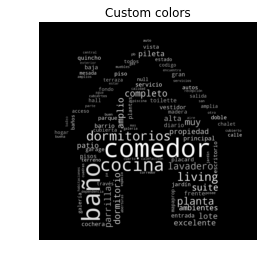

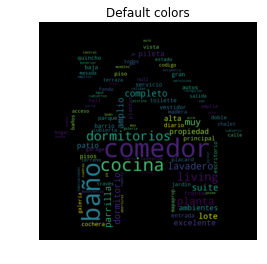

In [302]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"casa.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_house_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud per houses COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud per houses BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()


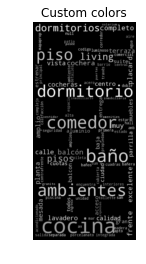

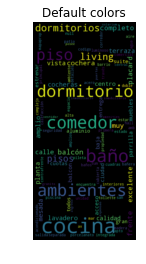

In [303]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"edificio2.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_apartment_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud per apartments COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud per apartments BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

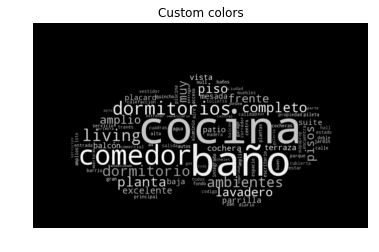

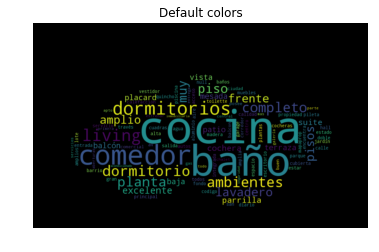

In [304]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes"

# read the mask image
mask = np.array(Image.open(path.join(d,"nube.jpg")))

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
#stopwords.add("int")
#stopwords.add("ext")

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_all_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud all in COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud all in BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()